In [1]:
"""a toy stroop model
"""
import numpy as np 
import psyneulink as pnl 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

sns.set(
    style='white', context='talk', palette='colorblind',
    font_scale=1, rc={"lines.linewidth": 2}
)
# sns.palplot(sns.color_palette('colorblind', n_colors=6))

In [2]:
def get_stroop_model():
    N_UNITS = 2
    # input layer, color and word
    inp_clr = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='Color input'
    )
    inp_wrd = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='Word input'
    )
    # task layer, represent the task instruction; color naming / word reading
    inp_task = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='Task input'
    )
    # hidden layer for color and word
    hidden_func = pnl.Logistic(gain=1.0, x_0=4.0)
    hid_clr = pnl.TransferMechanism(
        size=N_UNITS, function=hidden_func, name='Color hidden'
    )
    hid_wrd = pnl.TransferMechanism(
        size=N_UNITS, function=hidden_func, name='Word hidden'
    )
    # output layer
    output = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Logistic, name='Output'
    )
    # PROJECTIONS, weights copied from cohen et al (1990)
    wts_clr_ih = pnl.MappingProjection(
        matrix=[[2.2, -2.2], [-2.2, 2.2]], name='Color input to hidden')
    wts_wrd_ih = pnl.MappingProjection(
        matrix=[[2.6, -2.6], [-2.6, 2.6]], name='Word input to hidden')
    wts_clr_ho = pnl.MappingProjection(
        matrix=[[1.3, -1.3], [-1.3, 1.3]], name='Color hidden to Output')
    wts_wrd_ho = pnl.MappingProjection(
        matrix=[[2.5, -2.5], [-2.5, 2.5]], name='Word hidden to Output')
    wts_tc = pnl.MappingProjection(
        matrix=[[4.0, 4.0], [0, 0]], name='Color naming')
    wts_tw = pnl.MappingProjection(
        matrix=[[0, 0], [4.0, 4.0]], name='Word reading')
    # build the model
    model = pnl.Composition(name='STROOP model')
    model.add_node(inp_clr)
    model.add_node(inp_wrd)
    model.add_node(hid_clr)
    model.add_node(hid_wrd)
    model.add_node(inp_task)
    model.add_node(output)
    # pathways 
    model.add_linear_processing_pathway([inp_clr, wts_clr_ih, hid_clr])
    model.add_linear_processing_pathway([inp_wrd, wts_wrd_ih, hid_wrd])
    model.add_linear_processing_pathway([hid_clr, wts_clr_ho, output])
    model.add_linear_processing_pathway([hid_wrd, wts_wrd_ho, output])
    model.add_linear_processing_pathway([inp_task, wts_tc, hid_clr])
    model.add_linear_processing_pathway([inp_task, wts_tw, hid_wrd])
    # collect the node handles
    nodes = [inp_clr, inp_wrd, inp_task, hid_clr, hid_wrd, output]
    return model, nodes

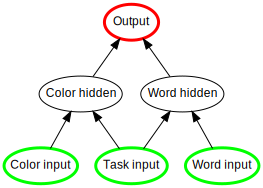

In [3]:
# get the model
model, nodes = get_stroop_model()
[color_inp, word_inp, task_inp, _, _, _] = nodes
model.show_graph(output_fmt = 'jupyter')

In [4]:
# define all stimuli 
all_conditions = ['control', 'conflict', 'congruent']
n_conditions = len(all_conditions)

red = [1, 0]
green = [0, 1]
null = [0, 0]
color_naming = [1, 0]
word_reading = [0, 1]

input_control = {color_inp: red,  word_inp: null, task_inp: color_naming}
input_conflict = {color_inp: red,  word_inp: green, task_inp: color_naming}
input_congruent = {color_inp: red,  word_inp: red, task_inp: color_naming}
all_stimuli = [input_control, input_conflict, input_congruent]

In [5]:
# run the model for all conditions
responses = []
for i, stimuli in enumerate(all_stimuli): 
    response = model.run(stimuli)
    responses.append(response)
    print(f'Condition: {all_conditions[i]} \t Response = {response}')
responses = np.squeeze(responses)

Condition: control 	 Response = [array([0.73897516, 0.26102484])]
Condition: conflict 	 Response = [array([0.63402068, 0.36597932])]
Condition: congruent 	 Response = [array([0.82226846, 0.17773154])]


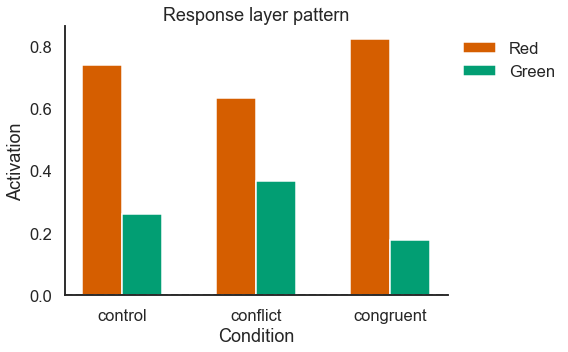

In [6]:
# prep data for plotting
colpal = sns.color_palette('colorblind', n_colors=4)[-2:]
index = np.arange(n_conditions)
bar_width = 0.3

# plot
f, ax = plt.subplots(1,1,figsize=(8,5))
ax.bar(
    index, responses[:,0], 
    bar_width, color=colpal[1], label='Red'
) 
ax.bar(
    index + bar_width, responses[:,1], 
    bar_width, color=colpal[0], label='Green'
)
ax.axhline(0, color='grey',linestyle='--')

ax.set_xlabel('Condition')
ax.set_ylabel('Activation')
ax.set_title('Response layer pattern')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(all_conditions)
ax.legend(bbox_to_anchor=(1,1),frameon=False)
 
plt.tight_layout()
sns.despine()

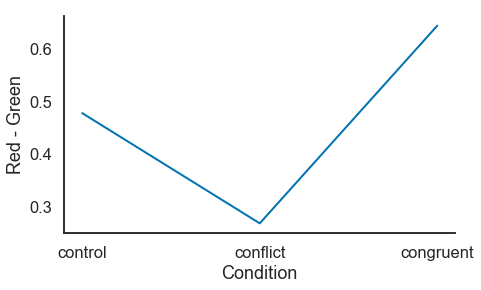

In [9]:
f, ax = plt.subplots(1,1,figsize=(7,4))
red_green_diff_color_naming = responses[:,0]-responses[:,1]
ax.plot(red_green_diff_color_naming)
ax.set_ylabel('Red - Green')
ax.set_xlabel('Condition')
ax.set_xticks(range(n_conditions))
ax.set_xticklabels(all_conditions)
sns.despine()

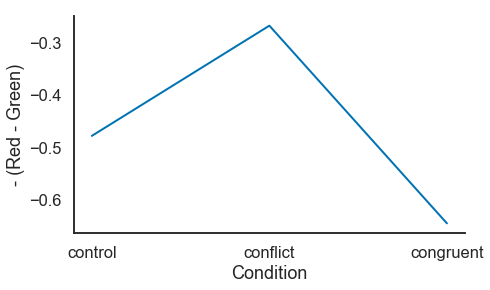

In [10]:
f, ax = plt.subplots(1,1,figsize=(7,4))
red_green_diff_color_naming = responses[:,0]-responses[:,1]
ax.plot(-red_green_diff_color_naming)
ax.set_ylabel('- (Red - Green)')
ax.set_xlabel('Condition')
ax.set_xticks(range(n_conditions))
ax.set_xticklabels(all_conditions)
sns.despine()